## LGD - Loss Given Default Model

This notebook aims to come up with a general methodology for developing a model for estimating LGD - Loss Given Default.

**LGD** represents the percentage of exposure that was lost after a borrower had defaulted.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.api import OLS

import warnings
warnings.filterwarnings("ignore")

from credit_risk_modeling.cleaning import DatetimeConverter, NumericExtractor
from credit_risk_modeling.eda import boxplot_by_categories
from credit_risk_modeling.feature_engineering import TimeSinceCalculator, OHECategoriesCreator
from credit_risk_modeling.models import ZeroInflatedXGBoost
from credit_risk_modeling.evaluation import get_regression_metrics, plot_regression_curves

#### Get data and select columns

In [2]:
selected_cols = [
    "id", "member_id", "loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length", 
    "home_ownership", "annual_inc", "issue_d", "loan_status", "purpose", "addr_state", "dti", "delinq_2yrs", 
    "earliest_cr_line", "verification_status", "initial_list_status", "inq_last_6mths", "open_acc", "pub_rec", 
    "total_acc", "total_rev_hi_lim", "recoveries"
]

In [3]:
df = pd.read_csv("../data/loan_data.csv")
df = df.loc[:, selected_cols]

#### Clean, Preprocess and Create Features

In [4]:
df["earliest_cr_line"].isnull().sum()

29

In [5]:
df["earliest_cr_line"] = df["earliest_cr_line"].fillna(df["issue_d"])

In [6]:
datetime_cols = ["earliest_cr_line", "issue_d"]
datetime_format = "%b-%y"
time_unit = "month"
reference_date = datetime(2017, 12, 1)

datetime_converter = DatetimeConverter(
    field_names=datetime_cols,
    datetime_format=datetime_format
)
df = datetime_converter.transform(df)

for datetime_col in datetime_cols:
    time_since_calculator = TimeSinceCalculator(
        field_name=datetime_col, reference_date=reference_date, time_unit=time_unit, winsorize_max=True,
    )
    df = time_since_calculator.transform(df)

In [7]:
emp_length_extractor = NumericExtractor(
    field_name="emp_length",
    regex_extraction=r"(.+)\syears?",
    post_mapping={r"10\+\s?": str(10), r"< 1\s?": str(0)},
)
df = emp_length_extractor.transform(df)

emp_length_extractor = NumericExtractor(
    field_name="term",
    regex_extraction=r"(\d+)",
)
df = emp_length_extractor.transform(df)

In order for us to continue with the analysis, we just need to carry out two additional steps:

* Define target variable

When building LGD models, it is good practice to build models with data from borrowers that have had enough time to repay part of the remaining debt.

Hence, we are going to take into account only borrowers that are written-off - which is indicated by `loan_status` equal to:

* `Charged Off`

* `Does not meet the credit policy. Status:Charged Off`

In [8]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Does not meet the credit policy. Status:Charged Off"
]

df = df[df["loan_status"].isin(DEFAULT_CATEGORIES)]

From the data provided, we know that:

* `funded_amnt`: reflects the total amount that was lost at the moment the borrower defaulted;

* `recoveries`: amount that has been recovered.

Hence, LGD can be defined as:

$LGD = \frac{funded\_amnt - recoveries}{funded\_amnt} = 1 - recovery\_rate$

For this particular problem, we will focus on developing a model for the `recovery rate` and then, in order to compute LGD, it is as simple as substracting this rate from 1.

In [9]:
TARGET_VARIABLE = "RR"

df[TARGET_VARIABLE] = df["recoveries"] / df["funded_amnt"]
df[TARGET_VARIABLE].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: RR, dtype: float64

We know that this value must be within the range [0, 1]. Hence:

In [10]:
df[TARGET_VARIABLE] = np.clip(df[TARGET_VARIABLE], a_min=0.0, a_max=1.0)

* Split our dataset into training and test, so that we avoid data leakage at all costs.

In [11]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=99)

From the visualizations below, we can easily notice that our target variable is unevenly distributed, with a lot of values concentrated around zero. Hence we will have to address this issue later on, since regular regression won't be able to deliver satisfactory results.

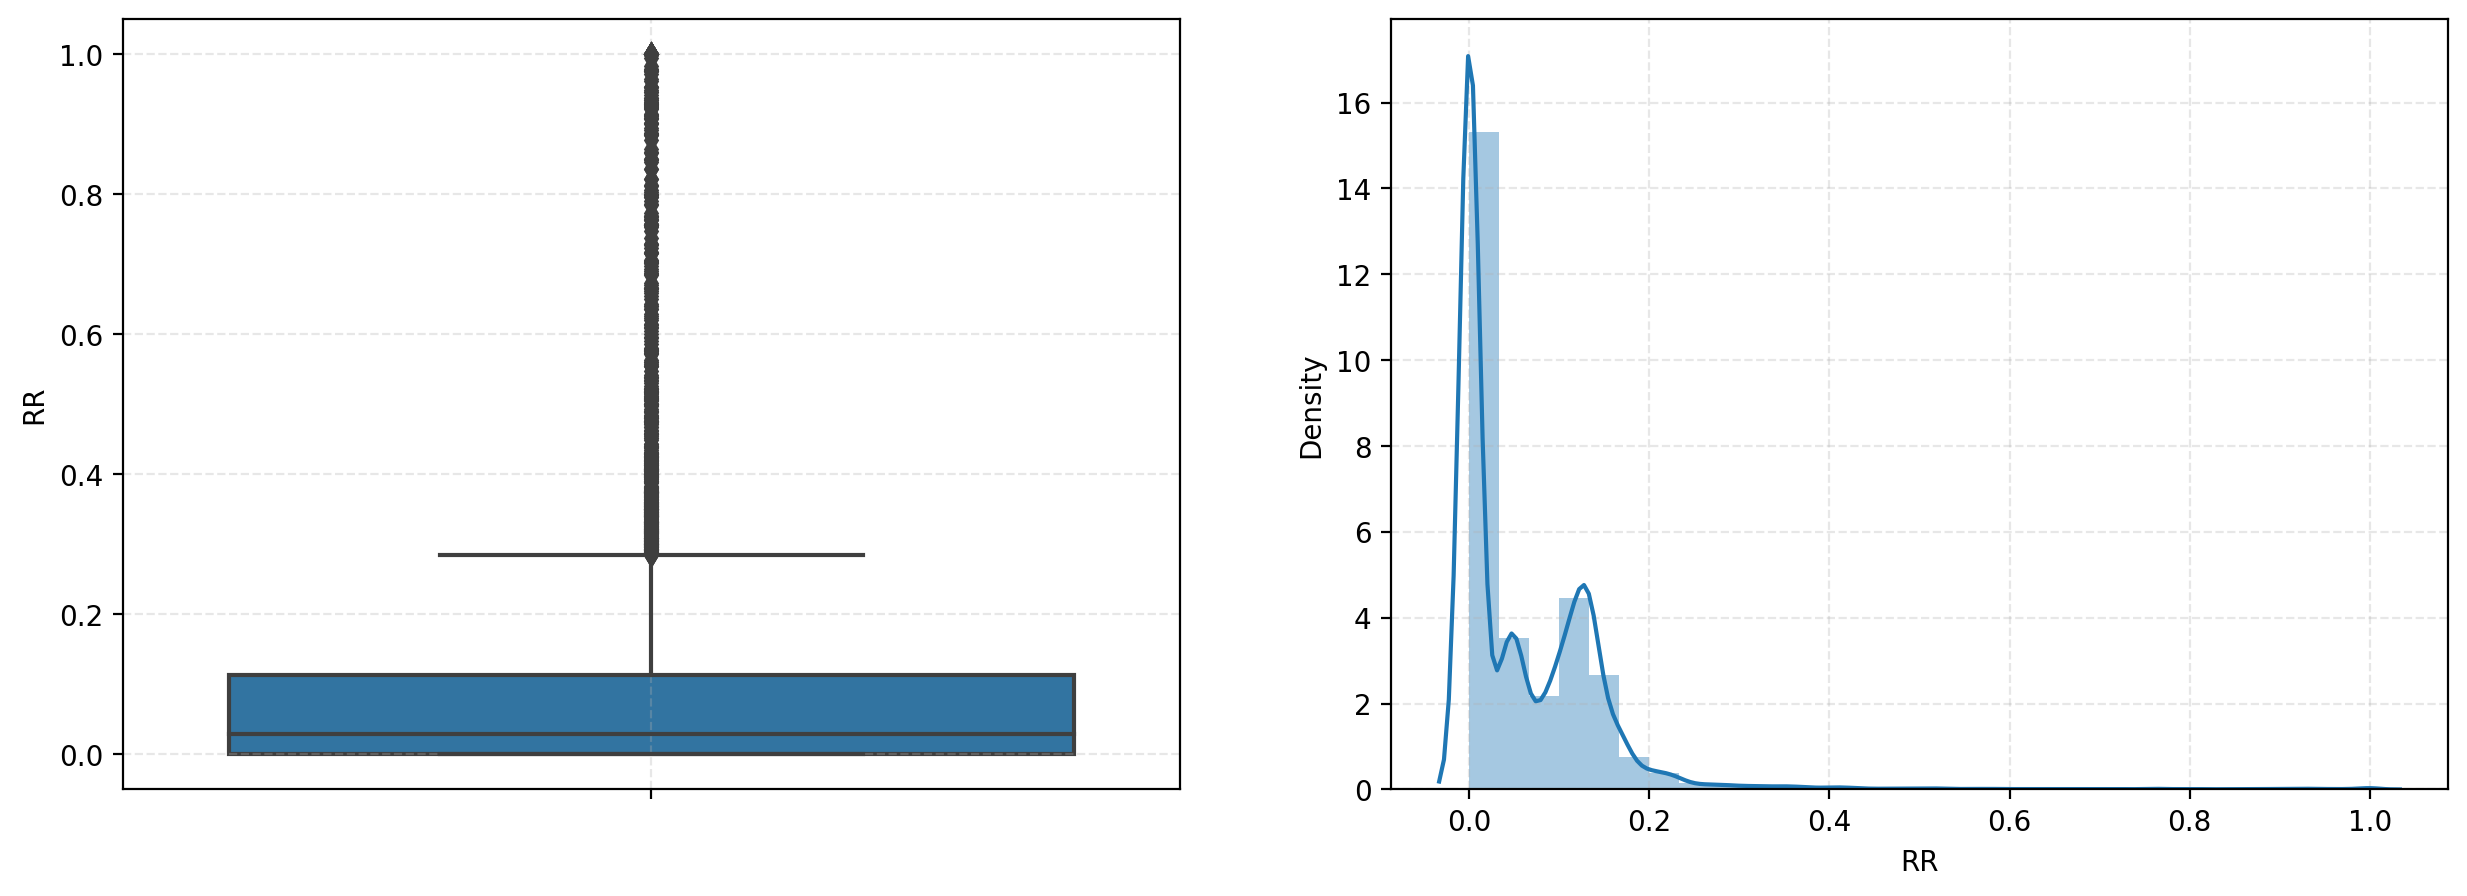

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df_train, y=TARGET_VARIABLE, ax=ax1)
ax1.grid(alpha=0.3, linestyle="--")
sns.distplot(df_train[TARGET_VARIABLE], bins=30, ax=ax2)
ax2.grid(alpha=0.3, linestyle="--")

plt.show()

#### Categorical Features

We will consider the categories we've come up with for the PD model, and take a look at how they are related to the target variable.

* `grade`
* `home_ownership`
* `addr_state`
* `verification_status`
* `purpose`
* `initial_list_status`

In [13]:
transformers = []
features = []
reference_categories = []

In [14]:
variable = "grade"
final_categories = {
    "A": ["A"],
    "B": ["B"],
    "C": ["C"],
    "D": ["D"],
    "E": ["E"],
    "F": ["F"],
    "G": ["G"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "G")

In [15]:
variable = "home_ownership"
final_categories = {
    "NONE_OTHER_RENT_ANY": ["NONE", "OTHER", "RENT", "ANY"],
    "MORTGAGE": ["MORTGAGE"],
    "OWN": ["OWN"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NONE_OTHER_RENT_ANY")

In [16]:
variable = "addr_state"
final_categories = {
    "NV_ND_ME_NE_IA": ["NV", "ND", "ME", "NE", "IA"],
    "HI": ["HI"],
    "FL": ["FL"],
    "AL_OK_LA": ["AL", "OK", "LA"],
    "NY": ["NY"],
    "MO": ["MO"],
    "MD_NJ_VA_NC_NM": ["NJ", "VA", "NC", "NM", "MD"],
    "CA": ["CA"],
    "TN_AZ_MI": ["TN", "AZ", "MI"],
    "KY_RI_ID": ["KY", "RI", "ID"],
    "PA_AR_OH_UT": ["PA", "AR", "OH", "UT"],
    "MN_MA_SD": ["MN", "MA", "SD"],
    "IN_OR_WA_GA": ["IN", "OR", "WA", "GA"],
    "WI_DE": ["WI", "DE"],
    "IL": ["IL"],
    "TX": ["TX"],
    "CT": ["CT"],
    "WV_KS_CO_SC": ["WV", "KS", "CO", "SC"],
    "MS_AK_MT_VT": ["MS", "AK", "MT", "VT"],
    "NH_WY_DC": ["NH", "WY", "DC"],   
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NV_ND_ME_NE_IA")

In [17]:
variable = "verification_status"
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "Verified")

In [18]:
variable = "purpose"
final_categories = {
    "car": ["car"],
    "credit_card": ["credit_card"],
    "major_purchase_home_improvement": ["major_purchase", "home_improvement"],
    "debt_consolidation": ["debt_consolidation"],
    "vacation_wedding": ["vacation", "wedding"],
    "medical": ['medical'],
    "other": ["other"],
    "renewable_energy_house_moving": ["renewable_energy", "house", "moving"],
    "educational_small_business": ["small_business", "educational"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "educational_small_business")

In [19]:
variable = "initial_list_status"
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "f")

##### EDA

In [20]:
boxplot_by_categories(df_train, features=features, target_variable=TARGET_VARIABLE)

44it [00:27,  1.59it/s]


It is quite interesting to note that the scenario is the opposite in comparison to the PD model: the riskier the category, the higher the recovery rate. It is very likely that the reason is related to the fact that for the riskiest borrowers, loan is granted for scenarios where there are some safeguards in place for the recovery of the value - which actually makes sense from a business perspective.

#### Numeric Features

Since we are developing a regression model, which is not required to be either explainable or interpretable by expternal regulator, there is no need for binning numeric variables. Thus, we can proceed straight to EDA. 